In [1]:
from importlib import reload
import random
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
random.seed(42)

import albumentations as A
import cv2
import numpy as np
import pandas as pd
import torch
from tqdm.auto import tqdm

from src.data import IDAOData, IDAODataTest, train_transforms, val_transforms

from src.data import CENTER, NORM_MEAN, NORM_STD

In [2]:
from src import preprocessing
reload(preprocessing)

<module 'src.preprocessing' from '/home/marina/Documents/IDAO/idao-squatting-slavs/src/preprocessing.py'>

In [15]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [4]:
# New directories
data_root = Path("data")

train_dir = data_root / "train"
val_dir = data_root / "val"
test_dir = data_root / "test"
test_holdout_dir = data_root / "test_holdout"
center = 120

In [6]:
# Check new datasets
train_ds = IDAOData(train_dir, transform=val_transforms(center))
# val_ds = IDAOData(val_dir, )
# test_ds = IDAOData(test_dir)
test_holdout_ds = IDAOData(test_holdout_dir, transform=val_transforms(center))
private_test_ds = IDAOData('idao_dataset/private_test', transform=val_transforms(center), is_train=False)
old_private_test_ds = IDAOData('idao_dataset/old_private_test', transform=val_transforms(center), is_train=False)

In [27]:
center = 10
transforms = val_transforms(center)
for ds in [train_ds, test_holdout_ds, private_test_ds, old_private_test_ds]:
    ds.transform = transforms

In [317]:
crop_dfs = []

for center in [10, 40, 80, 120]:
    df_list = []
    transforms = val_transforms(center)
    for ds, ds_name in zip([train_ds, test_holdout_ds, private_test_ds, old_private_test_ds],
                  ['train', 'test_holdout', 'private_test', 'old_private_test']):
        ds.transform = transforms
        for idx in tqdm(np.arange(len(ds))):
            [img_yx], r_type, energy, img_idx = ds[idx]
            img_yx[img_yx < 0] = 0
            sum_pixels, offset_x, offset_y, sq_dist, var = preprocessing.get_avg_value_and_distance(img_yx)
            out = {
                'ds_name': ds_name,
                'img_idx': img_idx, 
                'r_type': r_type,
                'energy': energy,
                f'sqrt_sum_pixels_{center}': np.sqrt(sum_pixels), 
#                 f'offset_x_{center}': offset_x, 
#                 f'offset_y_{center}': offset_y,
#                 f'sq_dist_{center}': sq_dist,
                f'sqrt_var_{center}': np.sqrt(var),
            }
            df_list.append(out)
    df = pd.DataFrame(df_list)
    crop_dfs.append(df)

In [318]:
df = pd.concat(crop_dfs, axis=1)
df = df.loc[:,~df.columns.duplicated()]
df['class'] = df['r_type'] + df['energy']

<IPython.core.display.Javascript object>


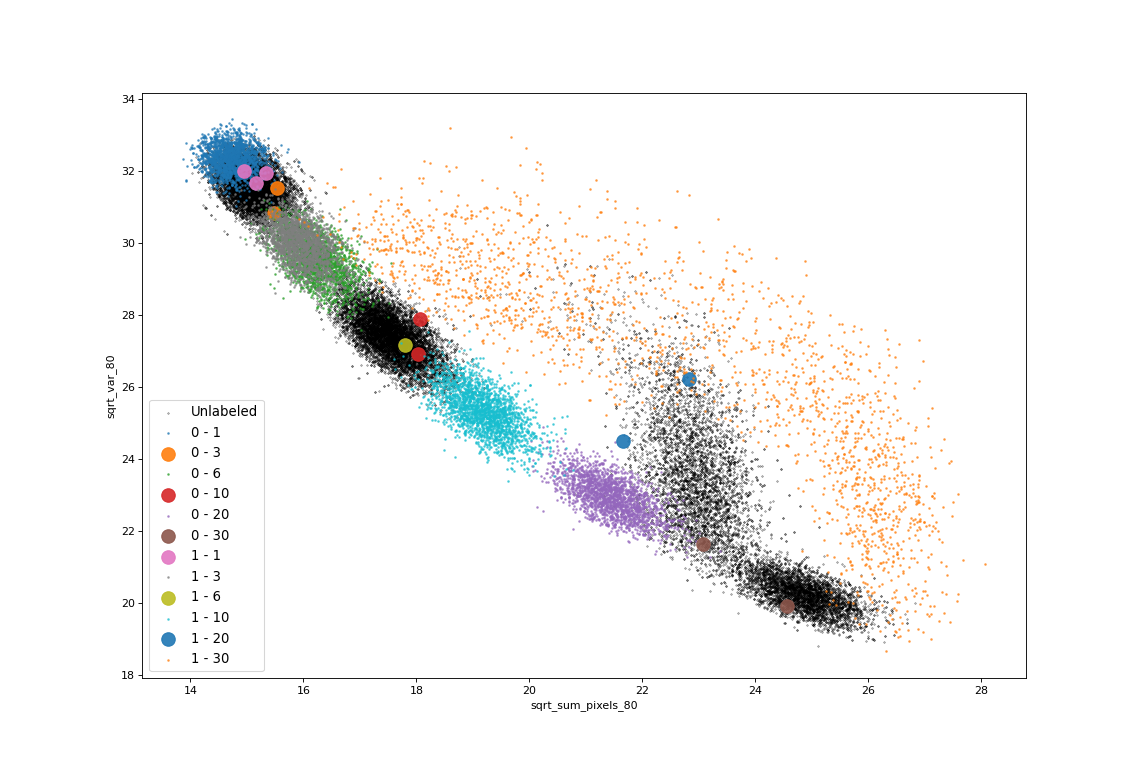

Text(0, 0.5, 'sqrt_var_80')

In [334]:
center = 80
col_x = f'sqrt_sum_pixels_{center}'
col_y = f'sqrt_var_{center}' # 'sq_dist'

fig, axis = plt.subplots(figsize=(10, 6))

mask = df['r_type'] == -1
axis.scatter(df[mask][col_x], 
            df[mask][col_y], 
             label='Unlabeled', marker='x', c='k', alpha=0.3, s=2)      
for r_type in [0, 1]:
    for energy in [1, 3, 6, 10, 20, 30]:
#     for energy in [3, 6]:
        
        mask = (df['r_type'] == r_type) & (df['energy'] == energy)
        if mask.sum() > 100:
            axis.scatter(df[mask][col_x], df[mask][col_y], 
                         label=f'{r_type} - {energy}', alpha=0.6, s=2)
        else:
            axis.scatter(df[mask][col_x], df[mask][col_y], 
                         label=f'{r_type} - {energy}', alpha=0.9, s=150)

  
# axis.set_xlim(0, 20)
axis.legend(fontsize='large')
axis.set_xlabel(col_x)
axis.set_ylabel(col_y)

In [286]:
subm = pd.read_csv('../old_track1_predictions_example.csv')

In [101]:
X = df.drop(columns=['ds_name', 'img_idx', 'r_type', 'energy', 'class']).values

In [102]:
uniq_train_classes = [1, 2, 3, 4, 6, 7, 10, 11, 20, 21, 30, 31] # sorted(df['class'].unique())

In [224]:
df

,ds_name,img_idx,r_type,energy,sum_pixels_10,var_10,sum_pixels_40,var_40,sum_pixels_80,var_80,sum_pixels_120,var_120,class
8313,train,-0.0026000000070780516__CYGNO_60_40_He_NR_6_ke...,0,6,4.805654,3.857844,10.223145,13.076354,16.213259,29.591600,22.803230,46.411014,6
5428,train,-0.0027000000700354576__CYGNO_60_40_He_NR_20_k...,0,20,9.760666,3.858732,16.949604,9.760620,21.048866,23.350089,26.485523,40.460538,20
1304,train,-0.003018522635102272__CYGNO_60_40_ER_30_keV_9...,1,30,4.157240,3.596947,13.489009,13.903147,26.189096,24.099240,30.718330,37.404889,31
10448,train,-0.0031084376387298107__CYGNO_60_40_ER_3_keV_9...,1,3,5.178988,3.745259,9.560925,12.625531,15.908581,30.094077,22.906464,47.045759,4
8876,train,-0.003241758095100522__CYGNO_60_40_ER_3_keV_93...,1,3,5.090540,3.685629,9.537395,13.312639,15.905496,30.051912,22.473688,46.579578,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16914,private_test,ffea775cbac98273943841d63b08377d29f08bc7,-1,-1,12.868465,3.862732,21.693293,9.162056,24.749332,19.270135,29.382980,35.719913,-2
16797,private_test,ffece3dcdcbe2d3125dbed1b8c77f2d6b4832580,-1,-1,6.688396,3.890904,12.498987,11.540842,17.868282,27.233196,24.101170,44.499426,-2
17330,private_test,ffed718417c6923844d33e70491c54396e3ec1ed,-1,-1,2.879525,3.857752,7.648553,14.791881,14.835137,31.828354,21.855949,48.410994,-2
37992,old_private_test,fff423086a80114984b647af69f710cf3ef844f9,-1,-1,3.399839,3.670568,8.742477,14.243530,15.753642,31.168176,22.727547,47.432430,-2


In [197]:
old_df = df.copy()

In [198]:
df = df.sort_values(by='img_idx')

In [199]:
df[df['ds_name'].isin(['train'])]['class'].unique()

array([ 6, 20, 31,  4, 11,  1])

In [200]:
data.shape

(15062, 8)

In [216]:
%matplotlib notebook

6
6


<IPython.core.display.Javascript object>


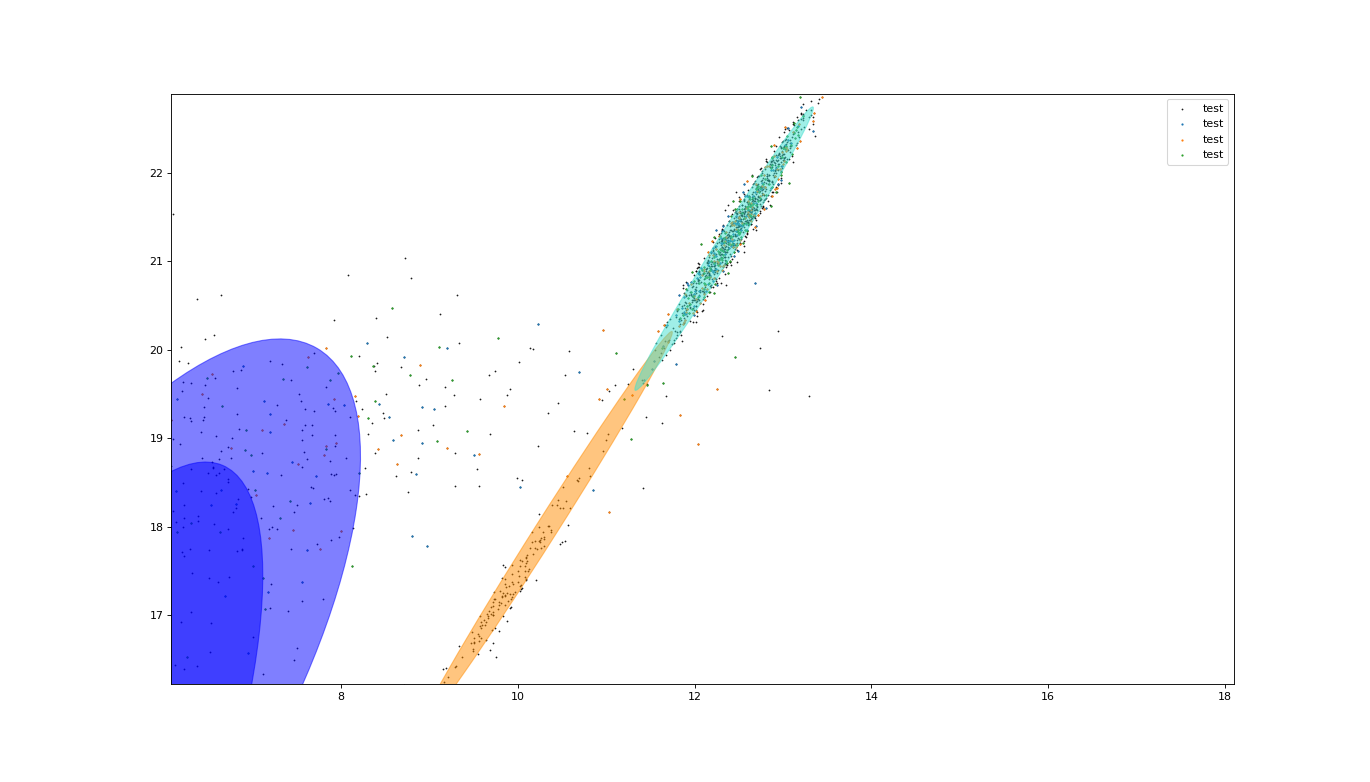

In [310]:
import matplotlib as mpl
from sklearn.mixture import GaussianMixture

colors = ['navy', 'turquoise', 'darkorange', 'green', 'grey', 'blue', 'navy', 'turquoise', 'darkorange', 'green', 'grey', 'blue', ]


def make_ellipses(gmm, ax, label=''):
    for n, color in enumerate(colors[:estimator.n_components]):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][components_2][:, components_2]
#         elif gmm.covariance_type == 'tied':
#             covariances = gmm.covariances_[:2, :2]
#         elif gmm.covariance_type == 'diag':
#             covariances = np.diag(gmm.covariances_[n][:2])
#         elif gmm.covariance_type == 'spherical':
#             covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, components_2], v[0], v[1],
                                  180 + angle, color=color, )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')

        
        
estimator = GaussianMixture(n_components=6, covariance_type='full', 
                            max_iter=50)

estimator_train = GaussianMixture(n_components=6, covariance_type='full', 
                            max_iter=50)

mask = df['ds_name'].isin(['train'])
X_train = X[mask]
y_train = np.array(df['class'][mask])
uniq_train_classes = sorted(df[mask]['class'].unique())
uniq_train_classes = [x for x in uniq_train_classes if x != -2]
print(len(uniq_train_classes))
estimator_train.means_init = np.array([X_train[y_train == i].mean(axis=0)
                                for i in uniq_train_classes])
estimator_train.fit(X_train)


# Since we have class labels for the training data, we can
# initialize the GMM parameters in a supervised manner.
mask = df['ds_name'].isin(['test_holdout'])
X_train = X[mask]
y_train = np.array(df['class'][mask])
uniq_train_classes = sorted(df[mask]['class'].unique())
uniq_train_classes = [x for x in uniq_train_classes if x != -2]
print(len(uniq_train_classes))
estimator.means_init = np.array([X_train[y_train == i].mean(axis=0)
                                for i in uniq_train_classes])



# mask = df['ds_name'].isin(['train', 'test_holdout', 'private_test',])
mask = df['ds_name'].isin(['old_private_test',])
X_train = X[mask]
y_train = np.array(df['class'][mask])
# uniq_train_classes = sorted(df[mask]['class'].unique())
# uniq_train_classes = [x for x in uniq_train_classes if x != -2]
# print(len(uniq_train_classes))

# estimator.means_init = np.array([X_train[y_train == i].mean(axis=0)
#                                 for i in uniq_train_classes])

# Train the other parameters using the EM algorithm.
estimator.fit(X_train)
# estimator.predict_proba


for components_2 in [
#     [0, 1],  [2, 3], 
    [0, 2],
#     [4, 5]
]:

    fig, axis = plt.subplots()
    make_ellipses(estimator_train, axis, 'train')
    make_ellipses(estimator, axis)
    # for n, color in enumerate(colors[:6]):
    #     data = X_train[y_train == uniq_train_classes[n]]
    #     plt.scatter(data[:, components_2[0]], data[:, components_2[1]],
    #                 s=0.8, color=color,
    #                 label=uniq_train_classes[n])

    
    data = X_train[y_train == -2]
    n = data.shape[0] // 2
    slc = slice(None, n)
    slc2 = slice(n, None)
    plt.scatter(data[slc, components_2[0]], data[slc, components_2[1]],
                s=0.3, color='k',label='test')
#     plt.scatter(data[slc2, components_2[0]], data[slc2, components_2[1]],
#                 s=0.3, color='k',label='test')

    step = 750
    for mult in range(5, 8):
        slc2 = slice(step * mult, step * (mult + 1))
        plt.scatter(data[slc2, components_2[0]], data[slc2, components_2[1]],
                    s=1, label='test')
    
    mask = (data[:, 0] > 10) & (data[:, 2] > 20)
#     plt.scatter(data[mask, components_2[0]], data[mask, components_2[1]],
#                 s=0.3, color='r',label='test')
    
    
    axis.legend()

In [ ]:
%matplotlib inline

In [281]:
mask = (data[:, 0] > 6) & (data[:, 2] < 11.5)

In [282]:
%matplotlib notebook

<IPython.core.display.Javascript object>


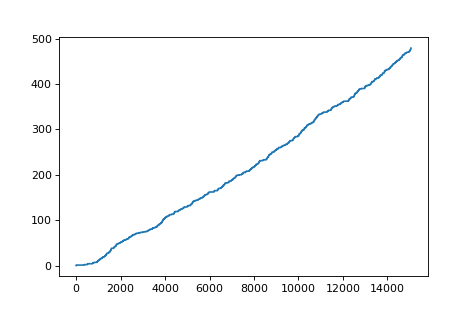

In [283]:

plt.plot(mask.cumsum())

In [ ]:
slc2"

In [163]:
data[slc2, components_2[0]].shape

(0,)

In [155]:
estimator.predict_proba(data).argmax(axis=1)

array([2, 2, 0, ..., 5, 3, 4])

In [150]:
    concat_dfs = []
for df in crop_dfs:
    cols = ['sum_pixels', 'offset_x', 'offset_y', 'sq_dist', 'var', 'r_type', 'energy']
    new_cols = [col + '_']
    df
    concat_dfs.append()

IndentationError: expected an indented block (<ipython-input-150-ede30f9d7cf9>, line 3)

In [43]:
crop_dfs[1].columns

Index(['img_idx', 'sum_pixels', 'offset_x', 'offset_y', 'sq_dist', 'var',
       'r_type', 'energy'],
      dtype='object')

In [315]:
%matplotlib notebook

In [ ]:
df

In [316]:
COLUMN_TYPE = 'var' # 'sq_dist'

fig, axis = plt.subplots(figsize=(16, 8))
for r_type in [0, 1]:
    for energy in [1, 3, 6, 10, 20, 30]:
#     for energy in [3, 6]:
        
        mask = (df['r_type'] == r_type) & (df['energy'] == energy)
        if mask.sum() > 100:
            axis.scatter(df[mask]['sum_pixels'], np.sqrt(df[mask][COLUMN_TYPE]), 
                         label=f'{r_type} - {energy}', alpha=0.6, s=2)
        else:
            axis.scatter(df[mask]['sum_pixels'], np.sqrt(df[mask][COLUMN_TYPE]), 
                         label=f'{r_type} - {energy}', alpha=0.9, s=150)

mask = df['r_type'] == -1
axis.scatter(df[mask]['sum_pixels'], 
             np.sqrt(df[mask][COLUMN_TYPE]), 
             label='Unlabeled', marker='x', c='b', alpha=0.6, s=2)        
axis.set_xlim(0, 20)
axis.legend()

<IPython.core.display.Javascript object>

KeyError: 'sum_pixels'

<IPython.core.display.Javascript object>


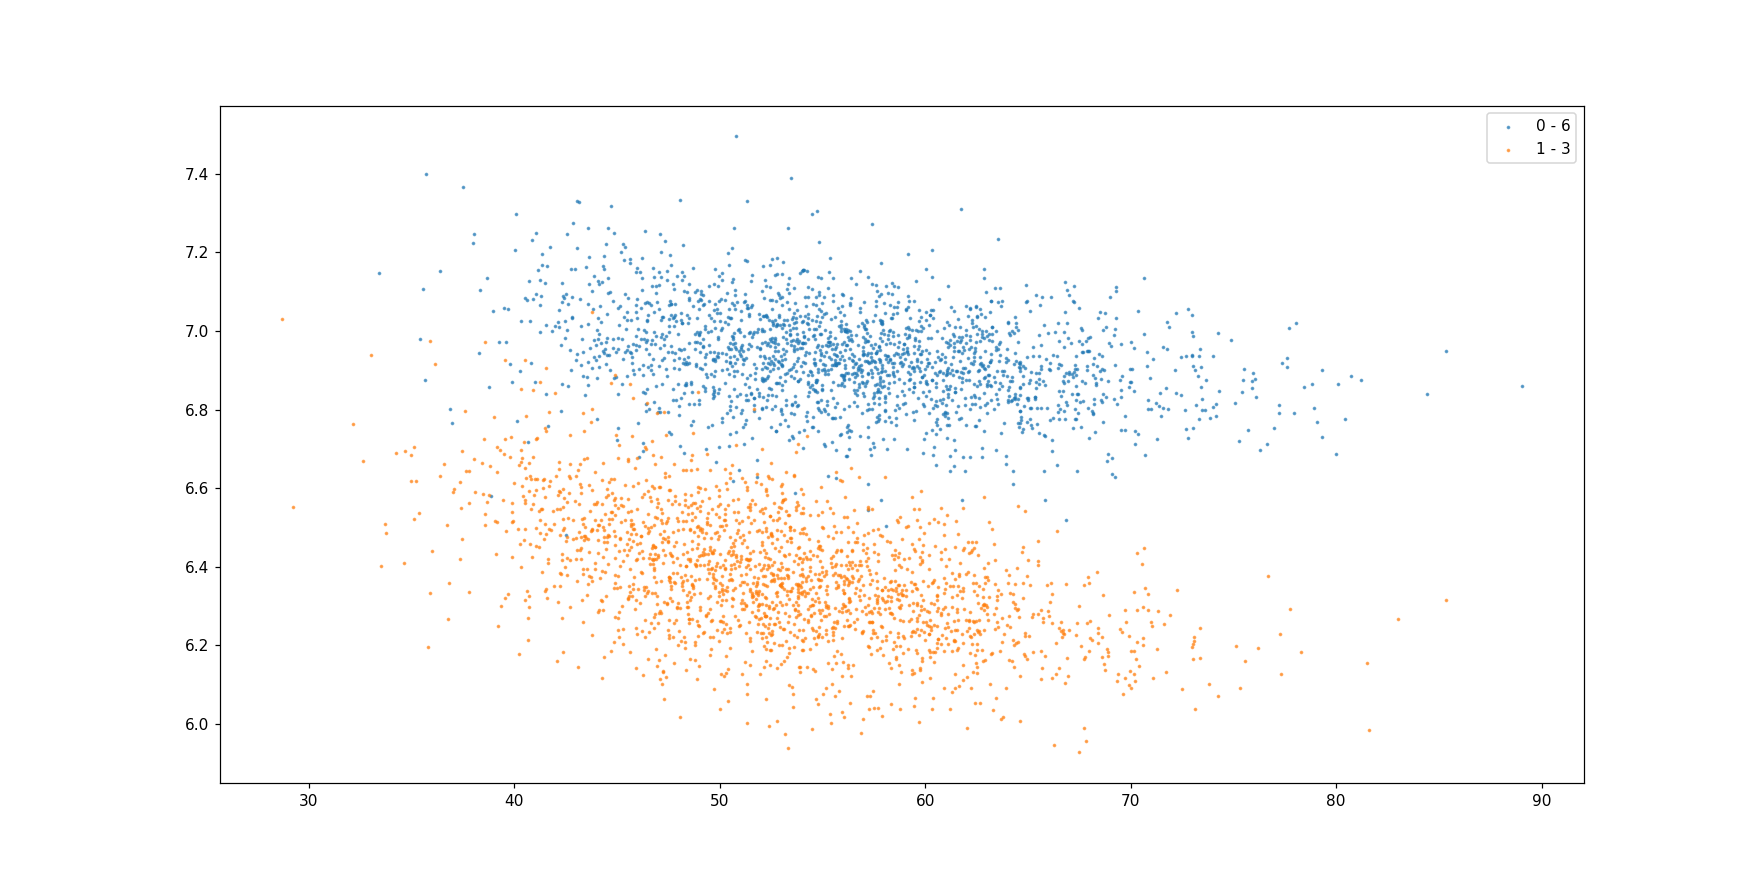

In [27]:
fig, axis = plt.subplots(figsize=(16, 8))
for r_type in [0, 1]:
#     for energy in [1, 3, 6, 10, 20, 30]:
    for energy in [3, 6]:
        
        mask = (df['r_type'] == r_type) & (df['energy'] == energy)
        if mask.sum() > 100:
            axis.scatter(df[mask]['sum_pixels'], np.sqrt(df[mask]['var']), 
                         label=f'{r_type} - {energy}', alpha=0.6, s=2)

        
axis.legend()

In [11]:
%matplotlib notebook

<IPython.core.display.Javascript object>


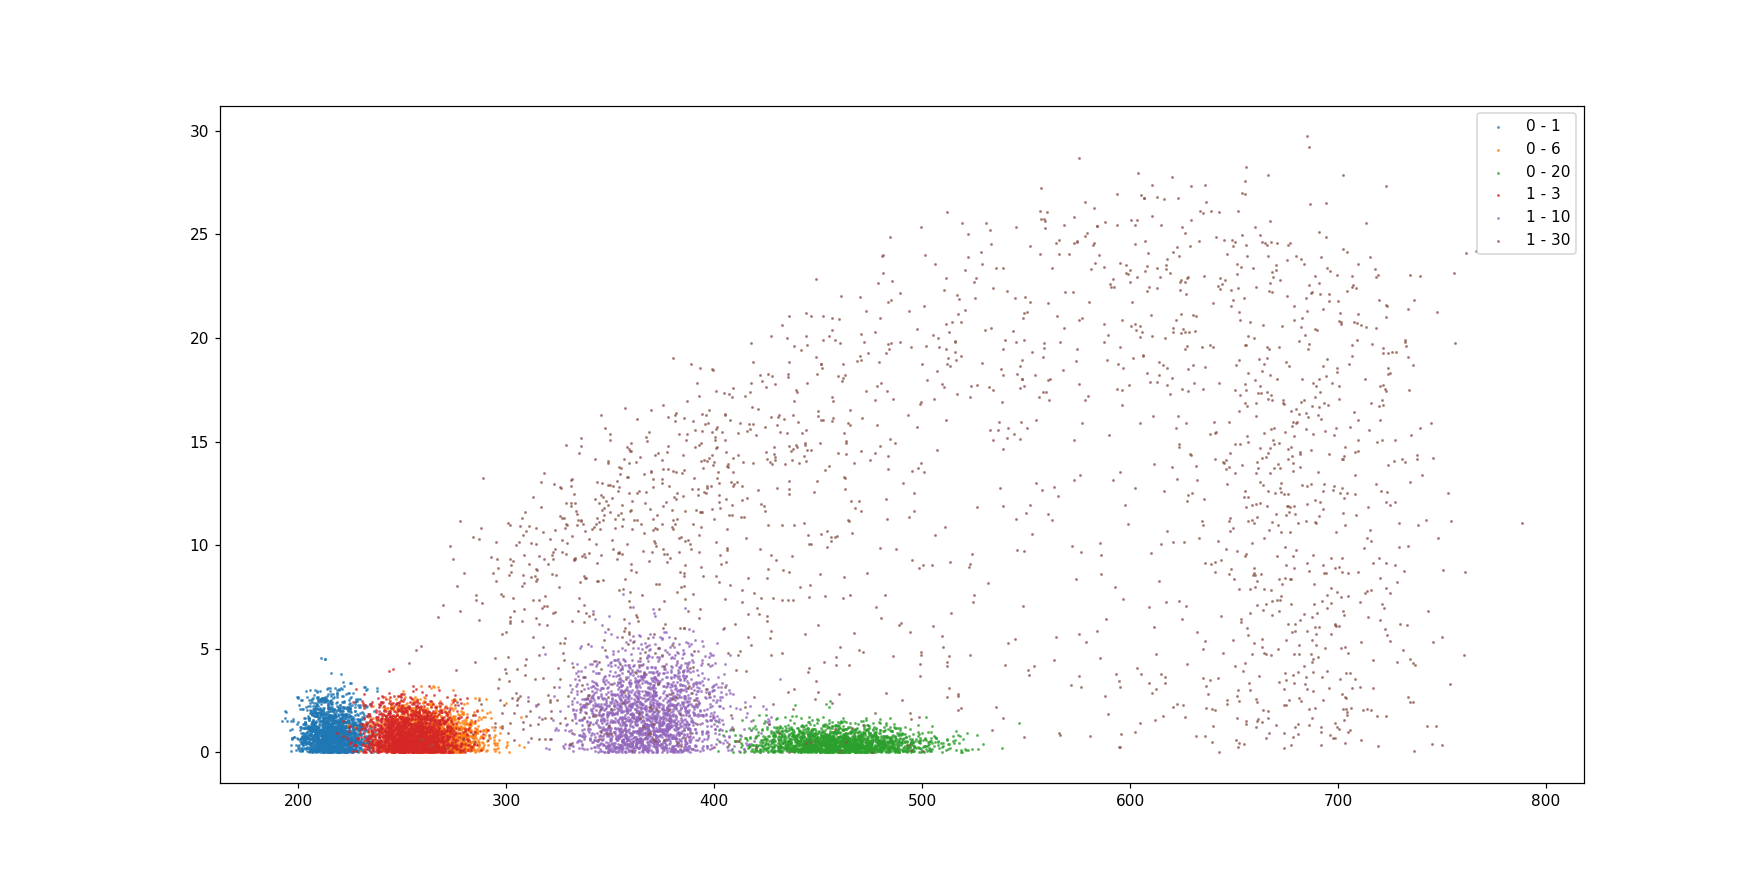

In [12]:
fig, axis = plt.subplots(figsize=(16, 8))
for r_type in [0, 1]:
    for energy in [1, 3, 6, 10, 20, 30]:
        mask = (df['r_type'] == r_type) & (df['energy'] == energy)
        if mask.sum() > 0:
            axis.scatter(df[mask]['sum_pixels'], 
                         np.sqrt(df[mask]['sq_dist']), 
#                          np.sqrt(df[mask]['var']), 
                         
                         label=f'{r_type} - {energy}', alpha=0.6, s=1)
        
axis.legend()

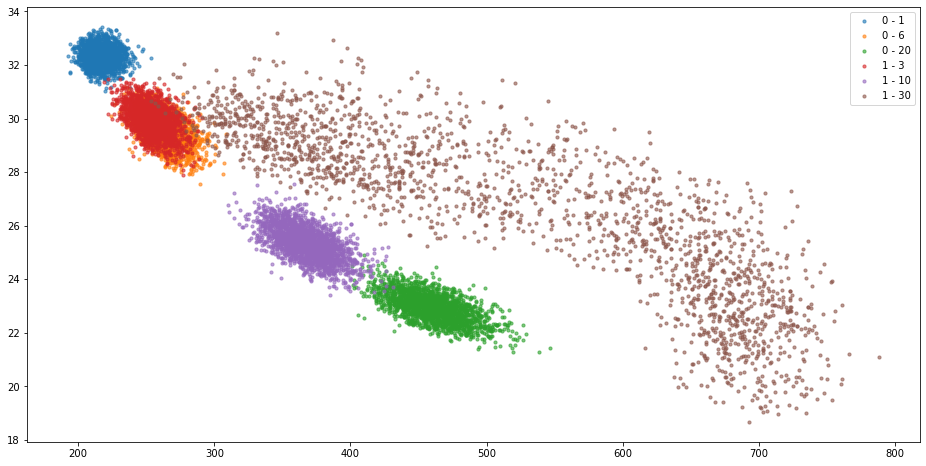

In [9]:
fig, axis = plt.subplots(figsize=(16, 8))
for r_type in [0, 1]:
    for energy in [1, 3, 6, 10, 20, 30]:
        mask = (df['r_type'] == r_type) & (df['energy'] == energy)
        if mask.sum() > 0:
            axis.scatter(df[mask]['sum_pixels'], np.sqrt(df[mask]['var']), 
                         label=f'{r_type} - {energy}', alpha=0.6, s=10)
        
axis.legend()